In [256]:
import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
 
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [257]:
# Set column dtypes for Pandas
from datetime import datetime
dt = datetime.utcnow()
COLUMN_NAMES = collections.OrderedDict({
  'Gmt time': object,
  'Open': np.float64,
  'High': np.float64,
  'Low': np.float64,
  'Close': np.float64,
  'Volume': np.float64,
  'Open_Bid': np.float64,
  'High_Bid': np.float64,
  'Low_Bid': np.float64,
  'Close_Bid': np.float64,
  'Volume_Bid': np.float64,
  'Spread': np.float64,
  'day_name': object,
  'weekday': 'category',#'category'np.int64
  'Pct_Range_Close': np.float64,
  'Pct_Range_Close_diff': np.float64,
  'MA_Close_5': np.float64,
  'MA_Close_25': np.float64,
  'MA_Close_50': np.float64,
  'MA_Close_200': np.float64,
  'EMA_Close_5': np.float64,
  'Momentum_1': np.float64,
  'Momentum_2': np.float64,
  'Momentum_5': np.float64,
  'Momentum_24': np.float64,
  'rsi': np.float64,
  'Rolling_Mean25': np.float64,
  'Bollinger_High': np.float64,
  'Bollinger_Low': np.float64,
  'PP': np.float64,
  'R1': np.float64,
  'S1': np.float64,
  'R2': np.float64,
  'S2': np.float64,
  'R3': np.float64,
  'S3': np.float64,
  'SO%k': np.float64,
  'SO%k1': np.float64,
  'SO%d2': np.float64,
  'Trix_5': np.float64,
  'MACD_5_25': np.float64,
  'MACDsign_5_25': np.float64,
  'MACDdiff_5_25': np.float64,
  'Mass_Index_25_8_9': np.float64,
  'Class': np.float64
})

In [258]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ',os.path.basename(file))

0   3C-EURUSD_FULL_1D_145F.csv
1   3C-EURUSD_FULL_1D_21F.csv
2   3C-EURUSD_FULL_1D_45F.csv
3   3C-EURUSD_FULL_1D_70F.csv
4   3C-EURUSD_FULL_1H_45F.csv
5   5C-EURUSD_FULL_1D_21F.csv
6   5C-EURUSD_FULL_1D_27F.csv
7   5C-EURUSD_FULL_1D_45F.csv
8   5C-EURUSD_FULL_1D_70F.csv
9   C-EURUSD_FULL_1D_21F.csv
10   C-EURUSD_FULL_1H_25F.csv
11   C-EURUSD_FULL_1H_45F.csv
12   C-EURUSD_FULL_1H_54F.csv


In [259]:
#SELECT an INDEX 
INDX = 0


START_AT = 0 #1725 para DIas
# El dataset original de 1H es de 102514 registros, OJO Revisar Volume de 0 a 45000


CLASS_NUMBER = '3C'
MODEL_TYPE = 'XGBOOST'
FRECUENCIA = '1D'
TARGET_NAME = "Class"
ID = '03'

PROFUNDIDAD = 5

TEST_SIZE = .20
VAL_SIZE = .10

In [260]:
# Load data into Pandas
data = pd.read_csv(filenames[INDX], 
  index_col=False,
  dtype=COLUMN_NAMES
)
data = data.dropna()

#data = shuffle(data, random_state=2)
data.head()

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738,0.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,...,90.553382,79.528156,-9.446618,0.0,1.260854,0.0,0.386229,0.385485,0.465272,0.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,...,95.306214,85.816835,-4.693786,0.0,1.265002,0.0,0.405326,0.404507,0.872484,0.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,...,72.223859,86.027818,-27.776141,0.0,1.268630,0.0,0.252306,0.251988,1.126991,-1.0


In [261]:
DATASET_ORIGINAL = data
print(data.shape)
data1 = data.iloc[START_AT:]
data1.reset_index(drop=True, inplace=True)
data = data1
print(data.shape)
print(data)

(5137, 145)
(5137, 145)
        Gmt time     Open     High      Low    Close        Volume  Open_Bid  \
0     2004-01-01  1.25950  1.26052  1.24698  1.25733  4.621817e+05   1.25934   
1     2004-01-02  1.25717  1.26282  1.25214  1.25832  1.066578e+06   1.25701   
2     2004-01-04  1.25925  1.26487  1.25789  1.26318  6.879980e+04   1.25855   
3     2004-01-05  1.26324  1.26935  1.26301  1.26830  1.119689e+06   1.26308   
4     2004-01-06  1.26836  1.28093  1.26666  1.27150  1.125442e+06   1.26820   
...          ...      ...      ...      ...      ...           ...       ...   
5132  2020-05-26  1.09019  1.09960  1.08970  1.09787  2.219154e+05   1.09015   
5133  2020-05-27  1.09788  1.10311  1.09342  1.10169  3.392159e+05   1.09785   
5134  2020-05-28  1.10168  1.10937  1.09919  1.10782  2.907155e+05   1.10165   
5135  2020-05-29  1.10780  1.11452  1.10702  1.11071  3.306924e+05   1.10778   
5136  2020-05-31  1.11213  1.11217  1.11028  1.11158  1.012642e+04   1.11129   

      High_Bid 

In [262]:
data.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Bid',
       'High_Bid', 'Low_Bid', 'Close_Bid',
       ...
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao',
       'momentum_kama', 'momentum_roc', 'others_dr', 'others_dlr', 'others_cr',
       'Class'],
      dtype='object', length=145)

In [263]:
data = data.drop(['Gmt time'], axis = 1)
data = data.drop(['day_name'], axis = 1)
data = data.drop(['weekday'], axis = 1)
data = data.drop(['Open_Bid'], axis = 1)
data = data.drop(['High_Bid'], axis = 1)
data = data.drop(['Low_Bid'], axis = 1)
data = data.drop(['Close_Bid'], axis = 1)



data = data.drop(['EMA_Close_5'], axis = 1)

data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,Class
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000,0.0
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738,0.0
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,90.553382,79.528156,-9.446618,0.0,1.260854,0.0,0.386229,0.385485,0.465272,0.0
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,95.306214,85.816835,-4.693786,0.0,1.265002,0.0,0.405326,0.404507,0.872484,0.0
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,72.223859,86.027818,-27.776141,0.0,1.268630,0.0,0.252306,0.251988,1.126991,-1.0


In [264]:
SIZE = data.shape[0]
NUM_FEATURES = data.shape[1]
print(SIZE)
print(NUM_FEATURES)

5137
137


In [265]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/XGBoost/')
#print('Location to Save: ', source_data)
FILENAME = CLASS_NUMBER + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + str(SIZE) + 'Size_' + MODEL_TYPE +  '_' + TARGET_NAME + "_"+ ID 
file_name_toSave = FILENAME + '.bst'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)

FILENAME:  3C_1D_137F_5137Size_XGBOOST_Class_03
File Name Model: 3C_1D_137F_5137Size_XGBOOST_Class_03.bst


In [266]:
train_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Train.csv')
print(train_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_137F_5137Size_XGBOOST_Class_03_Train.csv


In [267]:
test_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Test.csv')
print(test_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_137F_5137Size_XGBOOST_Class_03_Test.csv


In [268]:
# Label preprocessing
labels = data['Class'].values

# See the distribution of approved / denied classes (0: denied, 1: approved)
print(data['Class'].value_counts())

 0.0    3853
 1.0     646
-1.0     638
Name: Class, dtype: int64


In [269]:
data = data.drop(columns=['Class'])

In [270]:
def get_2Dimension(df, RANGE):
    new_df = pd.DataFrame()
    for i in range(RANGE):
#        new_df = df
        for j in range (df.shape[1]):
            #value = df.iloc[i+1,j]
            #print(value)
            new_col_name = df.columns[j] + '_' + str(i+1)
            #print(new_col_name)
            new_df[new_col_name] = df.iloc[i+1:,j]
            #print(new_df[new_col_name].isnull().sum())
            new_df.fillna(method='backfill', inplace=True)
            #print(new_df[new_col_name].isnull().sum())
    print(new_df.columns)
    return new_df

 


In [271]:
data

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000000,76.440177,76.440177,-23.559823,0.000000,1.257330,0.000000,-0.522913,0.000000,0.000000
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,25.516102,71.590909,74.015543,-28.409091,0.000000,1.257865,0.000000,0.078738,0.078707,0.078738
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,36.762821,90.553382,79.528156,-9.446618,0.000000,1.260854,0.000000,0.386229,0.385485,0.465272
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,44.645711,95.306214,85.816835,-4.693786,0.000000,1.265002,0.000000,0.405326,0.404507,0.872484
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,41.690793,72.223859,86.027818,-27.776141,0.000000,1.268630,0.000000,0.252306,0.251988,1.126991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132,1.09019,1.09960,1.08970,1.09787,2.219154e+05,2.075363e+05,0.00003,0.007045,0.007631,2.134402e+09,...,53.470734,87.194861,66.181299,-12.805139,0.005839,1.090343,1.224426,0.704464,0.701995,-12.682430
5133,1.09788,1.10311,1.09342,1.10169,3.392159e+05,3.194905e+05,0.00003,0.003479,-0.003565,2.134742e+09,...,60.537067,94.453125,78.650685,-5.546875,0.005649,1.092116,1.806605,0.347946,0.347343,-12.378612
5134,1.10168,1.10937,1.09919,1.10782,2.907155e+05,2.312052e+05,0.00003,0.005564,0.002085,2.135032e+09,...,63.147537,95.134965,92.260984,-4.865035,0.007610,1.095113,2.515176,0.556418,0.554876,-11.891071
5135,1.10780,1.11452,1.10702,1.11071,3.306924e+05,3.730174e+05,0.00035,0.002609,-0.002955,2.135363e+09,...,66.774381,89.705485,93.097858,-10.294515,0.011013,1.097529,2.655317,0.260873,0.260533,-11.661219


In [272]:
pd_old_rows = get_2Dimension(data,PROFUNDIDAD)

Index(['Open_1', 'High_1', 'Low_1', 'Close_1', 'Volume_1', 'Volume_Bid_1',
       'Spread_1', 'Pct_Range_Close_1', 'Pct_Range_Close_diff_1', 'AQV_1',
       ...
       'momentum_uo_5', 'momentum_stoch_5', 'momentum_stoch_signal_5',
       'momentum_wr_5', 'momentum_ao_5', 'momentum_kama_5', 'momentum_roc_5',
       'others_dr_5', 'others_dlr_5', 'others_cr_5'],
      dtype='object', length=680)


In [273]:
pd_old_rows.shape

(5136, 680)

In [274]:
data = pd.concat([data, pd_old_rows], axis=1, sort=False)
data.fillna(method='backfill', inplace=True)
data.shape

(5137, 816)

In [275]:
data.head(30)

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo_5,momentum_stoch_5,momentum_stoch_signal_5,momentum_wr_5,momentum_ao_5,momentum_kama_5,momentum_roc_5,others_dr_5,others_dlr_5,others_cr_5
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.000000,-0.607943,-0.609799,0.512196
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.000000,-0.607943,-0.609799,0.512196
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.000000,-0.607943,-0.609799,0.512196
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.000000,-0.607943,-0.609799,0.512196
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.000000,-0.607943,-0.609799,0.512196
5,1.27161,1.27417,1.26180,1.26377,1.111343e+06,1.345833e+06,0.00010,-0.006079,-0.008602,4.954033e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.000000,-0.607943,-0.609799,0.512196
6,1.26369,1.27854,1.25590,1.27696,1.115933e+06,1.348588e+06,0.00010,0.010437,0.016516,6.069966e+06,...,51.405206,88.306333,69.995091,-11.693667,0.003342,1.270900,0.000000,1.043703,1.038294,1.561245
7,1.27698,1.28676,1.27034,1.28149,1.066698e+06,1.274568e+06,0.00026,0.003547,-0.006890,7.136664e+06,...,58.689798,86.752137,74.837850,-13.247863,0.004954,1.275085,0.000000,0.354749,0.354121,1.921532
8,1.28279,1.28572,1.28253,1.28477,7.567420e+04,8.780950e+04,0.00010,0.002560,-0.000988,7.212338e+06,...,59.848956,94.997486,90.018652,-5.002514,0.006506,1.278809,0.000000,0.255952,0.255625,2.182402
9,1.28498,1.28971,1.27327,1.27390,1.110720e+06,1.341147e+06,0.00010,-0.008461,-0.011020,8.323059e+06,...,50.366111,63.000234,81.583286,-36.999766,0.006679,1.277300,0.000000,-0.846066,-0.849665,1.317872


In [276]:
# Convert categorical columns to dummy columns
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)

In [277]:
# Preview the data
data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo_5,momentum_stoch_5,momentum_stoch_signal_5,momentum_wr_5,momentum_ao_5,momentum_kama_5,momentum_roc_5,others_dr_5,others_dlr_5,others_cr_5
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.0,-0.607943,-0.609799,0.512196
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.0,-0.607943,-0.609799,0.512196
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.0,-0.607943,-0.609799,0.512196
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.0,-0.607943,-0.609799,0.512196
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.0,-0.607943,-0.609799,0.512196


In [278]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Bid', 'Spread',
       'Pct_Range_Close', 'Pct_Range_Close_diff', 'AQV',
       ...
       'momentum_uo_5', 'momentum_stoch_5', 'momentum_stoch_signal_5',
       'momentum_wr_5', 'momentum_ao_5', 'momentum_kama_5', 'momentum_roc_5',
       'others_dr_5', 'others_dlr_5', 'others_cr_5'],
      dtype='object', length=816)

In [279]:
# Split the data into train / test sets
x,y = data,labels
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size= TEST_SIZE, random_state=42, shuffle=False)

In [280]:
print(x_train.shape)
print(x_train)

(4109, 816)
         Open     High      Low    Close        Volume    Volume_Bid   Spread  \
0     1.25950  1.26052  1.24698  1.25733  4.621817e+05  5.597896e+05  0.00010   
1     1.25717  1.26282  1.25214  1.25832  1.066578e+06  1.277971e+06  0.00026   
2     1.25925  1.26487  1.25789  1.26318  6.879980e+04  8.372040e+04  0.00010   
3     1.26324  1.26935  1.26301  1.26830  1.119689e+06  1.353480e+06  0.00010   
4     1.26836  1.28093  1.26666  1.27150  1.125442e+06  1.354807e+06  0.00010   
...       ...      ...      ...      ...           ...           ...      ...   
4104  1.06575  1.06680  1.06079  1.06427  2.307331e+05  2.383420e+05  0.00030   
4105  1.06292  1.06382  1.06178  1.06191  5.538010e+03  5.510510e+03  0.00004   
4106  1.06189  1.06586  1.05922  1.05991  2.054674e+05  1.986187e+05  0.00004   
4107  1.05990  1.06335  1.05610  1.05785  2.206204e+05  2.200406e+05  0.00003   
4108  1.05785  1.06094  1.05216  1.06034  2.375658e+05  2.395418e+05  0.00004   

      Pct_Range

In [281]:
print(x_test.shape)
x_test.reset_index(drop=True, inplace=True)
print(x_test)

(1028, 816)
         Open     High      Low    Close       Volume   Volume_Bid   Spread  \
0     1.06034  1.06795  1.06001  1.06714  244667.6875  245245.1094  0.00002   
1     1.06710  1.06769  1.06056  1.06151  212225.3594  205934.2500  0.00037   
2     1.06094  1.06331  1.06087  1.06255    8377.2598    7770.8501  0.00004   
3     1.06252  1.06301  1.06034  1.06090  140458.7188  141470.8125  0.00002   
4     1.06091  1.06129  1.05259  1.05414  231237.8438  228481.8438  0.00004   
...       ...      ...      ...      ...          ...          ...      ...   
1023  1.09019  1.09960  1.08970  1.09787  221915.4388  207536.2810  0.00003   
1024  1.09788  1.10311  1.09342  1.10169  339215.8879  319490.5464  0.00003   
1025  1.10168  1.10937  1.09919  1.10782  290715.4826  231205.2051  0.00003   
1026  1.10780  1.11452  1.10702  1.11071  330692.3901  373017.4493  0.00035   
1027  1.11213  1.11217  1.11028  1.11158   10126.4174    9217.4834  0.00002   

      Pct_Range_Close  Pct_Range_Close_

In [282]:
print(y_test.shape)
print(y_test)

(1028,)
[0. 0. 0. ... 0. 0. 0.]


In [283]:
# Train the model, this will take a few minutes to run
bst = xgb.XGBClassifier(
    objective='reg:logistic'
)

bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [284]:
# Save the model so we can deploy it
#bst.save_model(source_data_toSave + file_name_toSave)

In [285]:
#bst_loaded = xgb.Booster({'nthread': 4})  # init model
#bst_loaded.load_model(source_data_toSave + file_name_toSave)  # load data

In [286]:
# Get predictions on the test set and print the accuracy score
y_pred = bst.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

0.8404669260700389 



In [287]:
# Print a confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

Confusion matrix:
[[0.         0.0790378  0.        ]
 [0.04347826 0.98854525 0.08139535]
 [0.02898551 0.09507446 0.01162791]]


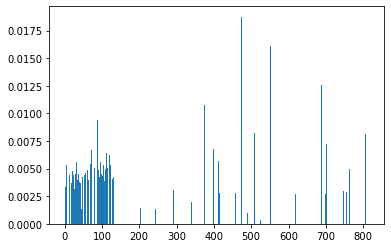

In [288]:

#print(bst.feature_importances_)
pyplot.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
pyplot.show()

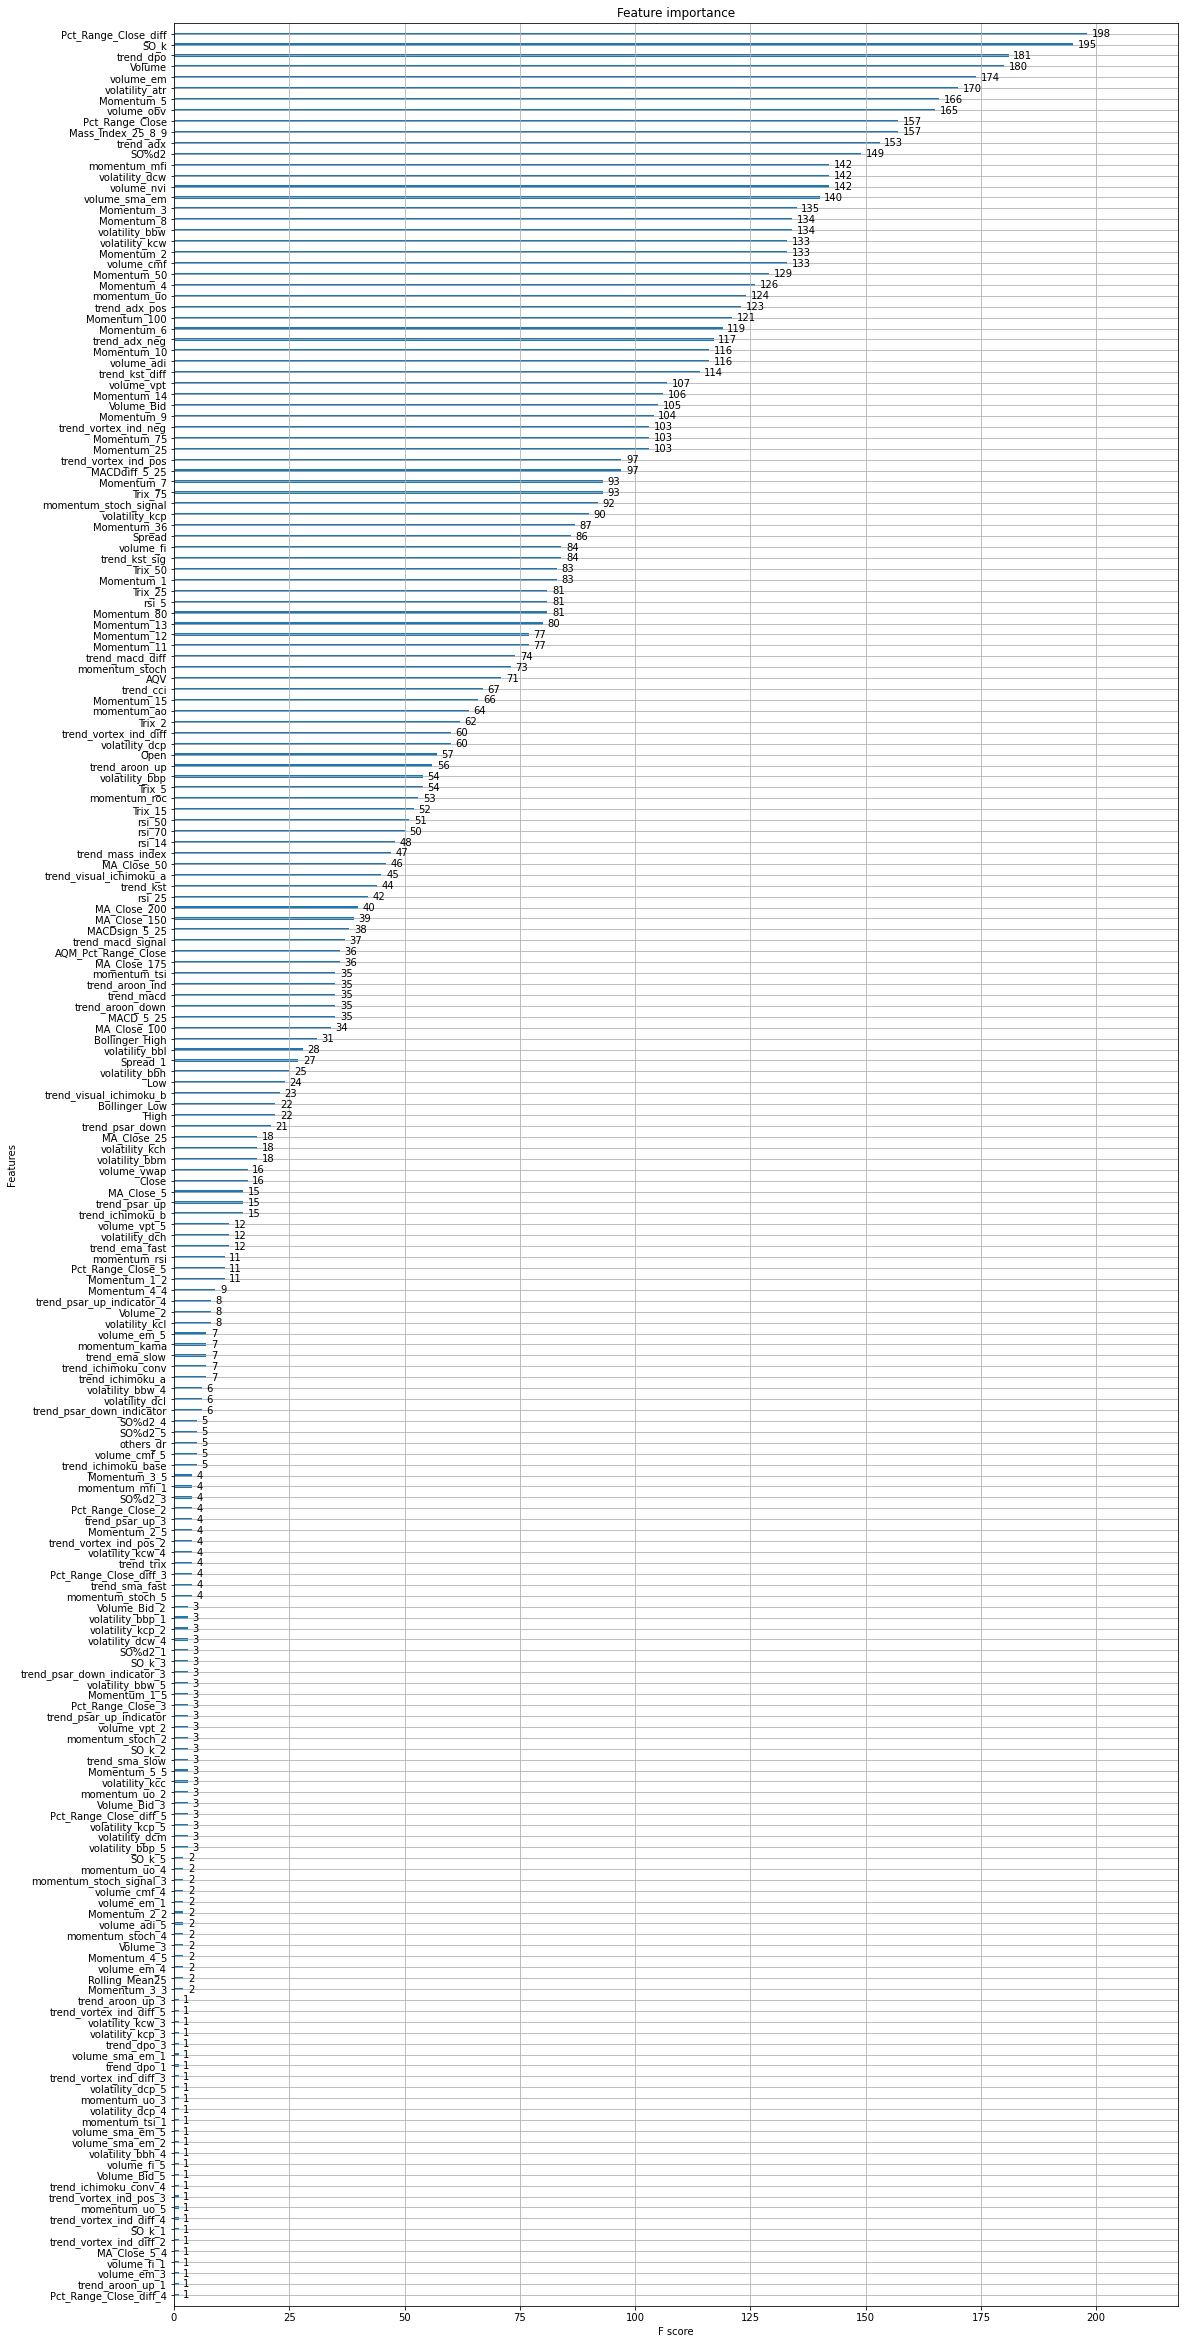

In [289]:
# plot feature importance
ax = plot_importance(bst)
fig = ax.figure
fig.set_size_inches(18, 42)
pyplot.show()

In [290]:
RUN_thresholds = False

# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

if (RUN_thresholds):
    # split data into X and y
    x,y = data,labels
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= TEST_SIZE, random_state=42,shuffle=False)

    # fit model on all training data
    model = MyXGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # Fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier()
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

### Predict Train Dataset

In [291]:
y_train_pred = bst.predict(x_train)
#x_train,x_test,y_train,y_test

In [292]:
y_train_real = pd.DataFrame({'Real_Class': y_train})
y_train_pred_pd = pd.DataFrame({'Predicted_Class': y_train_pred})
print('y_train_real ',y_train_real.shape)
print('y_train_pred_pd ',y_train_pred_pd.shape)
x_train_real = pd.concat([x_train,y_train_real], axis=1, sort=False)
print('x_train_real ',x_train_real.shape)
x_train = pd.concat([x_train_real,y_train_pred_pd], axis=1, sort=False)
print('x_train ', x_train.shape)

y_train_real  (4109, 1)
y_train_pred_pd  (4109, 1)
x_train_real  (4109, 817)
x_train  (4109, 818)


In [293]:
#Save
x_train.to_csv(train_dataset_results_csv, header=True, index=False)
print(train_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_137F_5137Size_XGBOOST_Class_03_Train.csv


### Predict Test Dataset

In [294]:
x_test.shape
x_test

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo_5,momentum_stoch_5,momentum_stoch_signal_5,momentum_wr_5,momentum_ao_5,momentum_kama_5,momentum_roc_5,others_dr_5,others_dlr_5,others_cr_5
0,1.06034,1.06795,1.06001,1.06714,244667.6875,245245.1094,0.00002,0.006413,0.004059,1.926086e+09,...,49.593917,48.731295,27.290475,-51.268705,-0.006197,1.062142,-0.842772,0.641304,0.639256,-15.126498
1,1.06710,1.06769,1.06056,1.06151,212225.3594,205934.2500,0.00037,-0.005276,-0.011689,1.926299e+09,...,48.350930,30.416396,35.252657,-69.583604,-0.006199,1.062088,-1.599058,-0.527578,-0.528975,-15.574272
2,1.06094,1.06331,1.06087,1.06255,8377.2598,7770.8501,0.00004,0.000980,0.006256,1.926307e+09,...,49.098484,37.644928,38.930873,-62.355072,-0.006382,1.062102,-1.458805,0.097974,0.097926,-15.491558
3,1.06252,1.06301,1.06034,1.06090,140458.7188,141470.8125,0.00002,-0.001553,-0.002533,1.926447e+09,...,48.430099,32.155997,33.405773,-67.844003,-0.006222,1.062035,-1.251001,-0.155287,-0.155408,-15.622788
4,1.06091,1.06129,1.05259,1.05414,231237.8438,228481.8438,0.00004,-0.006372,-0.004819,1.926679e+09,...,47.173881,7.407407,25.736111,-92.592593,-0.005971,1.061410,-1.287586,-0.637195,-0.639234,-16.160435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,1.09019,1.09960,1.08970,1.09787,221915.4388,207536.2810,0.00003,0.007045,0.007631,2.134402e+09,...,53.470734,87.194861,66.181299,-12.805139,0.005839,1.090343,1.224426,0.704464,0.701995,-12.682430
1024,1.09788,1.10311,1.09342,1.10169,339215.8879,319490.5464,0.00003,0.003479,-0.003565,2.134742e+09,...,60.537067,94.453125,78.650685,-5.546875,0.005649,1.092116,1.806605,0.347946,0.347343,-12.378612
1025,1.10168,1.10937,1.09919,1.10782,290715.4826,231205.2051,0.00003,0.005564,0.002085,2.135032e+09,...,63.147537,95.134965,92.260984,-4.865035,0.007610,1.095113,2.515176,0.556418,0.554876,-11.891071
1026,1.10780,1.11452,1.10702,1.11071,330692.3901,373017.4493,0.00035,0.002609,-0.002955,2.135363e+09,...,66.774381,89.705485,93.097858,-10.294515,0.011013,1.097529,2.655317,0.260873,0.260533,-11.661219


In [295]:
y_test_pred = bst.predict(x_test)
#x_train,x_test,y_train,y_test

In [296]:
y_test_pred.shape

(1028,)

In [297]:
y_test_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [298]:
y_test_real = pd.DataFrame({'Real_Class': y_test})
y_test_pred_pd = pd.DataFrame({'Predicted_Class': y_test_pred})
print('y_test_real ',y_test_real.shape)
print('y_test_pred_pd ',y_test_pred_pd.shape)
x_test_real = pd.concat([x_test,y_test_real], axis=1, sort=False)
print('x_test_real ',x_test_real.shape)
x_test = pd.concat([x_test_real,y_test_pred_pd], axis=1, sort=False)
print('x_test ', x_test.shape)

y_test_real  (1028, 1)
y_test_pred_pd  (1028, 1)
x_test_real  (1028, 817)
x_test  (1028, 818)


In [299]:

print(x_test['Predicted_Class'].isnull().sum())
#DATASET_FULL.fillna(method='backfill', inplace=True)

0


In [300]:
#Save
x_test.to_csv(test_dataset_results_csv, header=True, index=False)
print(test_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_137F_5137Size_XGBOOST_Class_03_Test.csv
